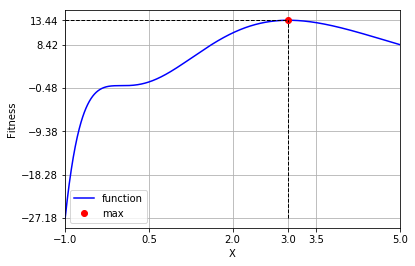

13.442508459323264


In [18]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline         
    
    
def Fitness(x):
    return 10 * x**3/np.exp(x)

x = np.linspace(-1,5, 1000)
y = Fitness(x)
max_ = np.max(y)
idx = np.argmax(y)
plt.plot(x,y, color='b', label='function')
plt.plot(x[idx], max_, 'o', color='r', label='max')
plt.plot(x[:idx], max_*np.ones((idx,)), '--', color='k', lw=1)
plt.plot(x[idx]*np.ones((idx)), y[:idx], '--', color='k', lw=1)
plt.xticks([x[idx]] + list(np.linspace(-1, 5, 5)))
plt.yticks([y[idx]] + list(np.linspace(y[0], y[-1], 5)))
plt.xlim([x[0], x[-1]])
plt.legend()
plt.xlabel('X')
plt.ylabel('Fitness')
plt.grid()
plt.show()
print(max_)

In [31]:
class GeneticAlgorithm(object):
    
    def __init__(self, bits=15, integers=5, pop_size=10, num_parents=0.3, num_generations=100, mutation_prob=0.05):
        self.bits = bits
        self.int = integers
        self.pop_size = pop_size
        self.num_parents = int(num_parents*pop_size)
        self.mutation_prob = mutation_prob
        self.offspring_size=(pop_size - self.num_parents, bits)
        self.num_generations = num_generations
        self.init_population = self.initial_population_fast()
        self.history = np.empty((pop_size, num_generations + 1))
        
    def create_indiv(self):
        return np.random.randint(0, 10, size=self.bits)
    
    def initial_population(self):
        population = []
        for i in range(0, self.pop_size):
            population.append(self.create_indiv())
        return population
    
    def initial_population_fast(self):
        return np.random.randint(0, 10, size=(self.pop_size, self.bits))
    
    def code(self, x):
        x = int(x * 10**(self.bits - self.int))/10**(self.bits - self.int)
        coding = []
        for i in range(self.bits):
            y = x // 10**(self.int - 1 -i)
            x -= y * 10**(self.int - 1 -i)
            coding.append(y)
        return coding
    
    def decode(self, coding):
        num = 0
        for i in range(self.bits):
            num += coding[i] * 10**(self.int - 1 - i)
        return int(num * 10**(self.bits - self.int))/10**(self.bits - self.int)

    def decode_pop(self, population):
        num = np.zeros((population.shape[0], ))
        for i in range(population.shape[1]):
            num += population[:, i] * 10**(self.int - i - 1)
        return np.round(num * 10**(self.bits - self.int))/10**(self.bits - self.int)
    
    def rank(self, population):
        fitness_result = {}
        decoded_population = self.decode_pop(population)
        for i in range(self.pop_size):
            fitness_result[i] = Fitness(decoded_population[i])
        return sorted(fitness_result.items(), key = operator.itemgetter(1), reverse = True)


    def select_mating_pool(self, population, rank):
        parents = np.empty((self.num_parents, self.bits))
        for i in range(self.num_parents):
            parent_num = rank[i][0]
            parents[i, :] = population[parent_num, :]
        return parents
    
    def crossover(self, parents, offspring_size):
        offspring = np.empty(offspring_size)
        # The point at which crossover takes place between two parents. Usually, it is at the center.
        crossover_point = np.random.randint(0, self.bits)

        for k in range(offspring_size[0]):
            # Index of the first parent to mate.
            parent1_idx = k%parents.shape[0]
            # Index of the second parent to mate.
            parent2_idx = (k+1)%parents.shape[0]
            # The new offspring will have its first half of its genes taken from the first parent.
            offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
            # The new offspring will have its second half of its genes taken from the second parent.
            offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
        return offspring
    
    def mutation(self, offspring_crossover):
        for i in range(offspring_crossover.shape[0]):
            if np.random.rand() < self.mutation_prob:
                new_value = np.random.randint(0, 10)
                position = np.random.randint(0, self.bits)
                offspring_crossover[i, position] = new_value
        return offspring_crossover
    
    def actualize_history(self, generation, rank):
        for i in range(len(rank)):
            self.history[i, generation] = rank[i][1]
            
    def show_history(self):
        x = np.linspace(0, self.num_generations, self.num_generations + 1)
        mean = np.mean(self.history, axis=0)
        max_ = np.max(self.history, axis=0)
        plt.plot(x, mean, label="mean", color='r')
        plt.plot(x, max_, label='max', color='b')
        plt.legend()
        plt.xlabel("num generation")
        plt.ylabel('Fitness')
        plt.ylim([0, 15])
        plt.show()
    
    def evolve(self, show=False):
        population = self.initial_population_fast()
        for generation in range(self.num_generations + 1):
            ranking = self.rank(population)
            self.actualize_history(generation, ranking)
            if show and (generation % int(self.num_generations / 10) == 0):
                print("%d) best fit: %0.3f" % (generation + 1, ranking[0][1]))
            if generation == self.num_generations:
                break

            # Selecting the best parents in the population for mating.
            parents = self.select_mating_pool(population, ranking)

            # Generating next generation using crossover.
            offspring_crossover = self.crossover(parents, self.offspring_size)

            # Adding some variations to the offsrping using mutation.
            offspring_mutation = self.mutation(offspring_crossover)

            # Creating the new population based on the parents and offspring.
            population[0:self.num_parents, :] = parents
            population[self.num_parents:, :] = offspring_mutation
            
        ranking = self.rank(population)
        win_idx = ranking[0][0]
        best_fit = ranking[0][1]
        winner = population[win_idx, :]
        if show:
            print("Best Gen -> ", winner)
            print("With Fitness: %0.3f" % best_fit)
            self.show_history()
        return winner, best_fit

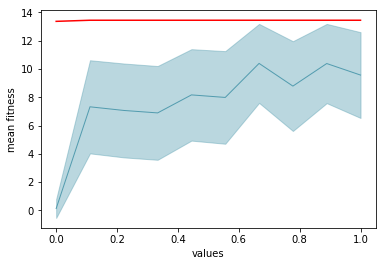

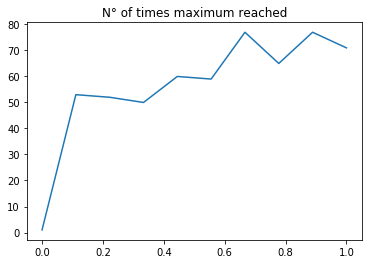

In [20]:
ga = GeneticAlgorithm(bits=15, integers=5, pop_size=10, num_parents=0.5, num_generations=100, mutation_prob=0.05)
w, fit = ga.evolve()

def test_mutation(iters, values):
    global_history = []
    max_history = []
    std_history = []
    total_correct = np.zeros((len(values),))
    for k, val in enumerate(values):
        local_history= []
        for i in range(iters):
            ga = GeneticAlgorithm(bits=15, integers=5, pop_size=100, num_parents=0.05, num_generations=100,
                                  mutation_prob=val)
            w, fit = ga.evolve()
            local_history.append(fit)
            if fit>13:
                total_correct[k] += 1
        global_history.append(np.mean(local_history))
        max_history.append(np.max(local_history))
        std_history.append(np.std(local_history))
        
        
    global_history = np.array(global_history)
    std_history = 0.5*np.array(std_history)
        
    plt.plot(values, global_history, lw = 1, color = '#539caf', alpha = 1, label = 'mean')
    # Shade the confidence interval
    plt.fill_between(values, global_history - std_history, global_history + std_history,
                     color = '#539caf', alpha = 0.4, label = '1-std')
    
    #plt.plot(values, global_history, label='mean')
    plt.plot(values, max_history, label='max', color='r', lw=1)
    plt.xlabel('values')
    plt.ylabel('mean fitness')
    plt.show()
    
    plt.plot(values, total_correct)
    plt.title('N° of times maximum reached')
    plt.show()
    
test_mutation(100, np.linspace(0, 1, 10))
        
    
        

[ 1 11 22 33 44 55 66 77 88 99]


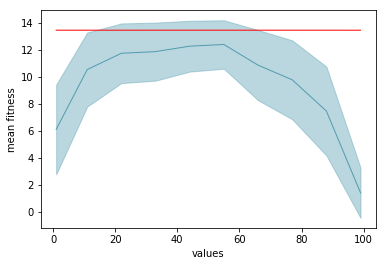

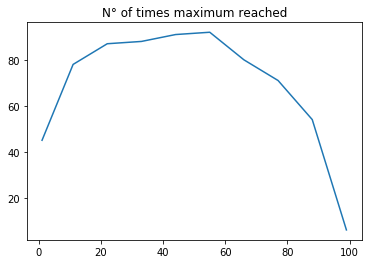

In [24]:
def test_parent(iters, values):
    assert np.max(values)<=1
    pop_size = 100
    values = np.array(values * pop_size).astype(np.int32)
    print(values)
    global_history = []
    max_history = []
    std_history = []
    total_correct = np.zeros((len(values),))
    for k, val in enumerate(values):
        local_history= []
        for i in range(iters):
            ga = GeneticAlgorithm(bits=15, integers=5, pop_size=pop_size, num_parents=val, num_generations=100,
                                  mutation_prob=0.7)
            w, fit = ga.evolve()
            local_history.append(fit)
            if fit>13:
                total_correct[k] += 1
        global_history.append(np.mean(local_history))
        max_history.append(np.max(local_history))
        std_history.append(np.std(local_history))
        
        
    global_history = np.array(global_history)
    std_history = 0.5*np.array(std_history)
        
    plt.plot(values, global_history, lw = 1, color = '#539caf', alpha = 1, label = 'mean')
    # Shade the confidence interval
    plt.fill_between(values, global_history - std_history, global_history + std_history,
                     color = '#539caf', alpha = 0.4, label = '1-std')
    
    #plt.plot(values, global_history, label='mean')
    plt.plot(values, max_history, label='max', color='r', lw=1)
    plt.xlabel('values')
    plt.ylabel('mean fitness')
    plt.show()
    
    plt.plot(values, total_correct)
    plt.title('N° of times maximum reached')
    plt.show()
    
test_parent(100, np.linspace(0.01, 0.99, 10))

In [38]:
def test_num_pop(iters, values):
    print(list(values))
    global_history = []
    max_history = []
    std_history = []
    total_correct = np.zeros((len(values),))
    for k, val in enumerate(values):
        local_history= []
        for i in range(iters):
            ga = GeneticAlgorithm(bits=15, integers=5, pop_size=val, num_parents=0.3, num_generations=50,
                                  mutation_prob=0.7)
            w, fit = ga.evolve()
            local_history.append(fit)
            if fit>13:
                total_correct[k] += 1
        global_history.append(np.mean(local_history))
        max_history.append(np.max(local_history))
        std_history.append(np.std(local_history))
        
        
    global_history = np.array(global_history)
    std_history = 0.5*np.array(std_history)
        
    plt.plot(values, global_history, lw = 1, color = '#539caf', alpha = 1, label = 'mean')
    # Shade the confidence interval
    plt.fill_between(values, global_history - std_history, global_history + std_history,
                     color = '#539caf', alpha = 0.4, label = '1-std')
    
    plt.plot(values, max_history, label='max', color='r', lw=1)
    plt.xlabel('values')
    plt.ylabel('mean fitness')
    plt.show()
    
    plt.plot(values, total_correct)
    plt.title('N° of times maximum reached')
    plt.show()
 

[5, 115, 226, 336, 447, 557, 668, 778, 889, 1000]


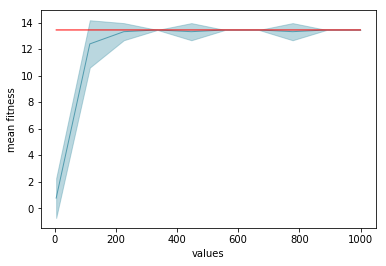

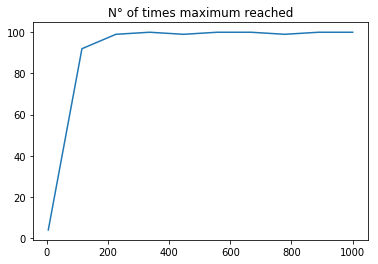

In [33]:
   
test_num_pop(100, np.linspace(5, 1000, 10).astype(np.int32))

[5, 26, 48, 70, 91, 113, 135, 156, 178, 200]


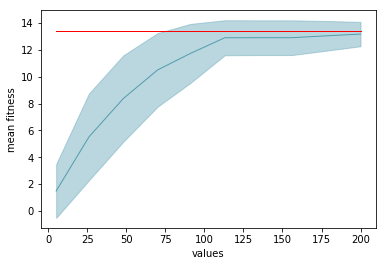

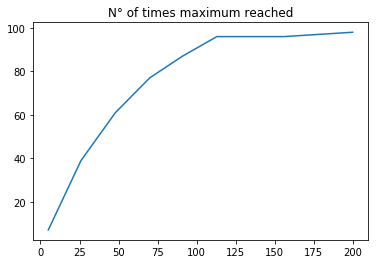

In [34]:
test_num_pop(100, np.linspace(5, 200, 10).astype(np.int32))

[5, 115, 226, 336, 447, 557, 668, 778, 889, 1000]


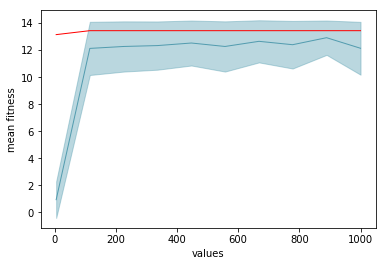

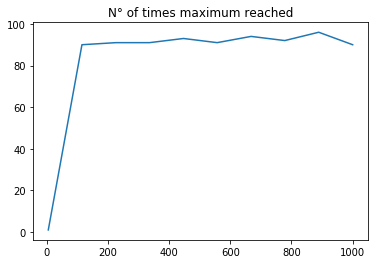

In [36]:
def test_num_gen(iters, values):
    print(list(values))
    global_history = []
    max_history = []
    std_history = []
    total_correct = np.zeros((len(values),))
    for k, val in enumerate(values):
        local_history= []
        for i in range(iters):
            ga = GeneticAlgorithm(bits=15, integers=5, pop_size=100, num_parents=0.3, num_generations=val,
                                  mutation_prob=0.7)
            w, fit = ga.evolve()
            local_history.append(fit)
            if fit>13:
                total_correct[k] += 1
        global_history.append(np.mean(local_history))
        max_history.append(np.max(local_history))
        std_history.append(np.std(local_history))
        
        
    global_history = np.array(global_history)
    std_history = 0.5*np.array(std_history)
        
    plt.plot(values, global_history, lw = 1, color = '#539caf', alpha = 1, label = 'mean')
    # Shade the confidence interval
    plt.fill_between(values, global_history - std_history, global_history + std_history,
                     color = '#539caf', alpha = 0.4, label = '1-std')
    
    plt.plot(values, max_history, label='max', color='r', lw=1)
    plt.xlabel('values')
    plt.ylabel('mean fitness')
    plt.show()
    
    plt.plot(values, total_correct)
    plt.title('N° of times maximum reached')
    plt.show()
    
test_num_gen(100, np.linspace(5, 1000, 10).astype(np.int32))

[5, 26, 48, 70, 91, 113, 135, 156, 178, 200]


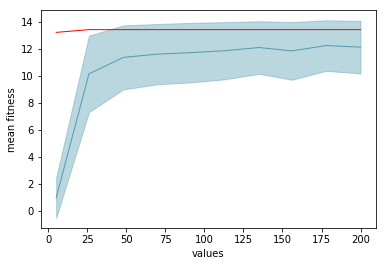

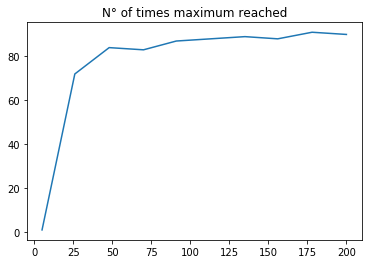

In [37]:
test_num_gen(100, np.linspace(5, 200, 10).astype(np.int32))

[5, 115, 226, 336, 447, 557, 668, 778, 889, 1000]


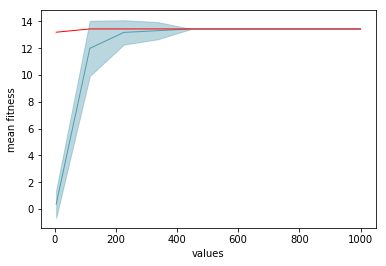

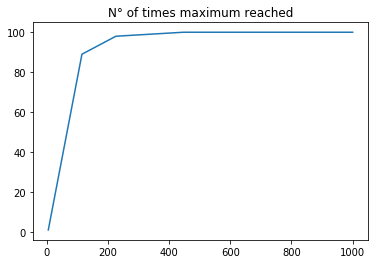

In [39]:
test_num_pop(100, np.linspace(5, 1000, 10).astype(np.int32))

[5, 26, 48, 70, 91, 113, 135, 156, 178, 200]


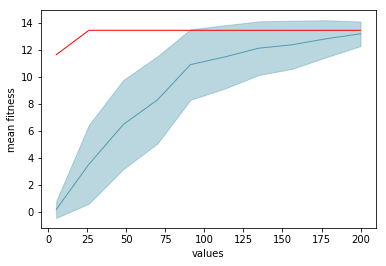

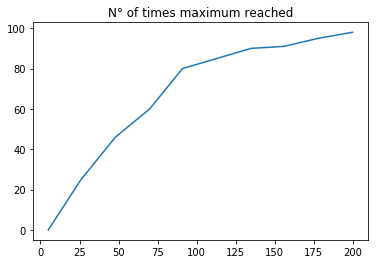

In [40]:
test_num_pop(100, np.linspace(5, 200, 10).astype(np.int32))

In [77]:
def test_num_gen_and_pop(iters, gen_values, pop_values):
    print(list(gen_values))
    print(list(pop_values))
    global_history = np.empty((len(gen_values), len(pop_values)))
    max_history = np.empty((len(gen_values), len(pop_values)))
    std_history = np.empty((len(gen_values), len(pop_values)))
    total_correct = np.zeros((len(gen_values), len(pop_values)))
    for g, g_val in enumerate(gen_values):
        for p, p_val in enumerate(pop_values):
            local_history= []
            for i in range(iters):
                ga = GeneticAlgorithm(bits=15, integers=5, pop_size=p_val, num_parents=0.3, num_generations=g_val,
                                      mutation_prob=0.7)
                w, fit = ga.evolve()
                local_history.append(fit)
                if fit>13:
                    total_correct[g, p] += 1
            global_history[g,p] = np.mean(local_history)
            max_history[g,p] = np.max(local_history)
            std_history[g,p] = 0.5*np.std(local_history)
    return global_history, max_history, std_history, total_correct

In [51]:
gen_values = np.linspace(5, 200, 10).astype(np.int32)
pop_values = np.linspace(5, 200, 10).astype(np.int32)
global_history, max_history, std_history, total_correct = test_num_gen_and_pop(100, gen_values, pop_values)

[5, 26, 48, 70, 91, 113, 135, 156, 178, 200]
[5, 26, 48, 70, 91, 113, 135, 156, 178, 200]


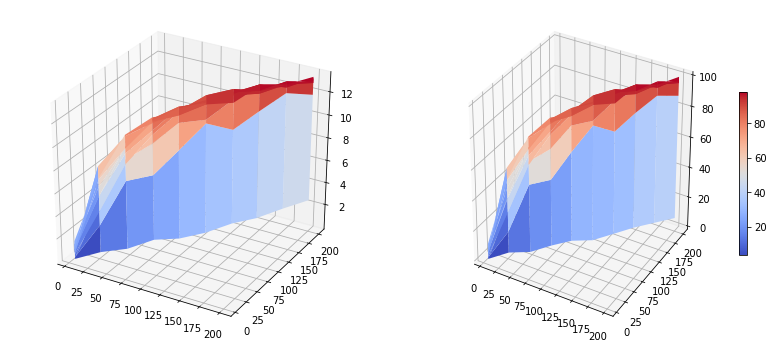

In [52]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from pylab import *
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1,2,1, projection='3d')
p = ax.plot_surface(gen_values, pop_values, global_history, rstride=1, cstride=1, cmap=cm.coolwarm, lw=0)
ax = fig.add_subplot(1,2,2, projection='3d')
p = ax.plot_surface(gen_values, pop_values, total_correct, rstride=1, cstride=1, cmap=cm.coolwarm, lw=0)
cb = fig.colorbar(p, shrink=0.5)




[[  0.   2.   0.   2.   3.   1.   3.   5.   6.   7.]
 [  1.  16.  45.  46.  62.  77.  71.  81.  90.  88.]
 [  0.  32.  60.  66.  79.  80.  91.  95.  98.  96.]
 [  2.  29.  58.  75.  86.  90.  95.  95.  96.  98.]
 [  5.  38.  64.  77.  90.  92.  94.  93.  97.  98.]
 [  5.  39.  69.  84.  90.  91.  96.  99.  95.  99.]
 [  8.  45.  68.  85.  90.  91.  96.  95.  97.  98.]
 [  3.  50.  68.  83.  85.  90.  95.  99.  97.  96.]
 [  6.  58.  75.  82.  88.  96.  98.  95.  99.  97.]
 [ 10.  51.  76.  86.  86.  90.  89.  98.  97. 100.]]


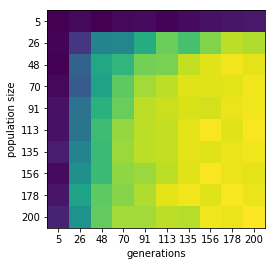

In [60]:
print(total_correct)
plt.imshow(total_correct)
plt.xlabel('generations')
plt.ylabel('population size')
plt.xticks(np.linspace(0,9,10), gen_values)
plt.yticks(np.linspace(0,9,10), pop_values)
plt.show()

In [63]:
gen_values = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
pop_values = gen_values
global_history, max_history, std_history, total_correct = test_num_gen_and_pop(100, gen_values, pop_values)

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


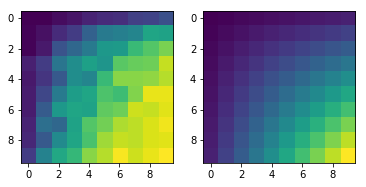

In [67]:
plt.subplot(1,2,1)
plt.imshow(total_correct)
plt.subplot(1,2,2)
plt.imshow(np.dot(gen_values.reshape(10,1), pop_values.reshape(1,10)))
plt.show()

In [75]:
computos = np.dot(gen_values.reshape(10,1), pop_values.reshape(1,10)).astype(np.int32)
for i in range(10):
    for j in range(10):
        print('(%d,%d)' % (total_correct[i,j], computos[i,j]), end='')
    print('\n')

(0,100)(0,200)(3,300)(5,400)(9,500)(11,600)(12,700)(17,800)(18,900)(22,1000)

(1,200)(4,400)(11,600)(16,800)(28,1000)(37,1200)(39,1400)(41,1600)(53,1800)(52,2000)

(1,300)(6,600)(23,900)(30,1200)(37,1500)(48,1800)(49,2100)(61,2400)(66,2700)(72,3000)

(8,400)(16,800)(35,1200)(44,1600)(51,2000)(47,2400)(67,2800)(69,3200)(70,3600)(82,4000)

(6,500)(14,1000)(25,1500)(44,2000)(41,2500)(61,3000)(74,3500)(74,4000)(75,4500)(80,5000)

(7,600)(19,1200)(37,1800)(50,2400)(53,3000)(65,3600)(62,4200)(73,4800)(87,5400)(87,6000)

(7,700)(26,1400)(48,2100)(53,2800)(52,3500)(68,4200)(70,4900)(83,5600)(82,6300)(86,7000)

(9,800)(33,1600)(30,2400)(52,3200)(66,4000)(71,4800)(79,5600)(81,6400)(85,7200)(88,8000)

(10,900)(25,1800)(43,2700)(53,3600)(64,4500)(77,5400)(82,6300)(81,7200)(85,8100)(86,9000)

(16,1000)(40,2000)(54,3000)(60,4000)(74,5000)(80,6000)(89,7000)(83,8000)(87,9000)(90,10000)



In [76]:
print(total_correct)

[[ 0.  0.  3.  5.  9. 11. 12. 17. 18. 22.]
 [ 1.  4. 11. 16. 28. 37. 39. 41. 53. 52.]
 [ 1.  6. 23. 30. 37. 48. 49. 61. 66. 72.]
 [ 8. 16. 35. 44. 51. 47. 67. 69. 70. 82.]
 [ 6. 14. 25. 44. 41. 61. 74. 74. 75. 80.]
 [ 7. 19. 37. 50. 53. 65. 62. 73. 87. 87.]
 [ 7. 26. 48. 53. 52. 68. 70. 83. 82. 86.]
 [ 9. 33. 30. 52. 66. 71. 79. 81. 85. 88.]
 [10. 25. 43. 53. 64. 77. 82. 81. 85. 86.]
 [16. 40. 54. 60. 74. 80. 89. 83. 87. 90.]]


In [78]:
gen_values = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
pop_values = gen_values
global_history, max_history, std_history, total_correct = test_num_gen_and_pop(100, gen_values, pop_values)

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


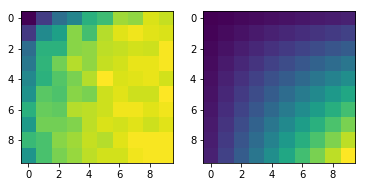

In [79]:
plt.subplot(1,2,1)
plt.imshow(total_correct)
plt.subplot(1,2,2)
plt.imshow(np.dot(gen_values.reshape(10,1), pop_values.reshape(1,10)))
plt.show()

In [80]:
print(total_correct)

[[ 8. 24. 41. 49. 65. 70. 85. 83. 93. 90.]
 [23. 51. 59. 82. 71. 88. 94. 96. 94. 93.]
 [40. 66. 66. 82. 83. 89. 90. 92. 91. 97.]
 [44. 67. 79. 88. 83. 90. 92. 95. 95. 97.]
 [50. 66. 74. 80. 88. 98. 93. 94. 95. 92.]
 [54. 75. 73. 82. 80. 91. 94. 91. 91. 98.]
 [65. 77. 76. 88. 89. 91. 96. 96. 94. 96.]
 [57. 79. 79. 81. 89. 93. 92. 94. 91. 94.]
 [69. 72. 82. 85. 90. 88. 94. 97. 97. 97.]
 [55. 72. 80. 84. 89. 92. 92. 96. 97. 97.]]


In [81]:
computos = np.dot(gen_values.reshape(10,1), pop_values.reshape(1,10)).astype(np.int32)
for i in range(10):
    for j in range(10):
        print('(%d,%d)' % (total_correct[i,j], computos[i,j]), end='')
    print('\n')

(8,100)(24,200)(41,300)(49,400)(65,500)(70,600)(85,700)(83,800)(93,900)(90,1000)

(23,200)(51,400)(59,600)(82,800)(71,1000)(88,1200)(94,1400)(96,1600)(94,1800)(93,2000)

(40,300)(66,600)(66,900)(82,1200)(83,1500)(89,1800)(90,2100)(92,2400)(91,2700)(97,3000)

(44,400)(67,800)(79,1200)(88,1600)(83,2000)(90,2400)(92,2800)(95,3200)(95,3600)(97,4000)

(50,500)(66,1000)(74,1500)(80,2000)(88,2500)(98,3000)(93,3500)(94,4000)(95,4500)(92,5000)

(54,600)(75,1200)(73,1800)(82,2400)(80,3000)(91,3600)(94,4200)(91,4800)(91,5400)(98,6000)

(65,700)(77,1400)(76,2100)(88,2800)(89,3500)(91,4200)(96,4900)(96,5600)(94,6300)(96,7000)

(57,800)(79,1600)(79,2400)(81,3200)(89,4000)(93,4800)(92,5600)(94,6400)(91,7200)(94,8000)

(69,900)(72,1800)(82,2700)(85,3600)(90,4500)(88,5400)(94,6300)(97,7200)(97,8100)(97,9000)

(55,1000)(72,2000)(80,3000)(84,4000)(89,5000)(92,6000)(92,7000)(96,8000)(97,9000)(97,10000)

